# Drift correciton for raw CG-5 data

by: Mareen Loesing, Lu Li, UWA


Here, we show how to load raw gravity measurement from CG-5, and do drift correction

In [1]:
# Load necessary package 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Proj
from scipy.interpolate import interp1d
from datetime import datetime

# Read in CG-5 Gravity Data

In [2]:
#works for CG5 output, needs to be changed for CG6
names = ['LINE', 'STATION', 'ALT.', 'GRAV.', 'SD.', 'TILTX', 'TILTY', 'TEMP', 'TIDE', 'DUR', 'REJ', 'TIME', 'DEC.TIME+DATE', 'TERRAIN', 'DATE']
Data = pd.read_csv('example data/Grav_CAGE_AF.txt', skiprows=34, names=names, delimiter=r'\s+')

In [3]:
Data = Data.assign(DATE=pd.to_datetime(Data['DATE'], format='%Y/%m/%d'))
Data = Data.assign(DateTime=pd.to_datetime(Data['DATE'].dt.strftime('%Y-%m-%d') 
                                                       + ' ' + Data['TIME'], format='%Y-%m-%d %H:%M:%S'))

Data.loc[:,'DateTime'] = pd.to_datetime(Data['DateTime'])

datetime_values = Data['DateTime'].copy()
datetime_strings = [str(dt) for dt in datetime_values]

reference_time = min(datetime.strptime(dt, '%Y-%m-%d %H:%M:%S') for dt in datetime_strings)
seconds_elapsed = [(datetime.strptime(dt, '%Y-%m-%d %H:%M:%S') - reference_time).total_seconds() for dt in datetime_strings]
Data.loc[:,'seconds_elapsed'] = seconds_elapsed



C:\Users\00103168\AppData\Local\Temp\ipykernel_25956\1304826768.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  Data.loc[:,'DateTime'] = pd.to_datetime(Data['DateTime'])


In [4]:
# Let's looks few line of the data
Data.head(5)

,LINE,STATION,ALT.,GRAV.,SD.,TILTX,TILTY,TEMP,TIDE,DUR,REJ,TIME,DEC.TIME+DATE,TERRAIN,DATE,DateTime,seconds_elapsed
0,0.0,5000.0,20.0682,6491.527,0.051,72.9,93.2,-3.43,-0.085,30,0,10:47:19,45283.44881,0.0,2024-01-24,2024-01-24 10:47:19,0.0
1,0.0,5000.0,20.3123,6491.618,0.073,48.4,78.9,-3.50,-0.085,30,0,10:49:36,45283.45039,0.0,2024-01-24,2024-01-24 10:49:36,137.0
2,0.0,5000.0,20.3123,6491.577,0.087,46.7,83.0,-3.56,-0.085,30,0,10:51:18,45283.45157,0.0,2024-01-24,2024-01-24 10:51:18,239.0
3,0.0,5000.0,20.5565,6491.516,0.904,33.1,80.9,-3.62,-0.085,30,5,10:52:49,45283.45262,0.0,2024-01-24,2024-01-24 10:52:49,330.0
4,0.0,5001.0,20.5526,6558.234,0.901,33.1,81.0,-3.62,-0.085,30,5,10:52:51,45283.45264,0.0,2024-01-24,2024-01-24 10:52:51,332.0


# Read GPS data

In [5]:
GPS_Data = pd.read_csv('example data/GPS_CAGE_AF.csv', skiprows=0, delimiter=r',')

In [6]:
GPS_Data.head(2)

,LINE,STATION,LONGITUDE,LATITUDE,HEIGHT_SEA_LEVEL_M
0,0,5000,21.077,-31.156,1096.9
1,0,5001,20.011,-31.593,1119.4


# Match Gravity with GPS data

In [7]:
Combine_data = pd.merge(Data, GPS_Data, on=['LINE', 'STATION'], how='left')


In [8]:
# Base Station (STATION 5000, use the station number in your data file)
Data_control = Combine_data[Combine_data.STATION==5000]

In [9]:
Combine_data.head(2)

,LINE,STATION,ALT.,GRAV.,SD.,TILTX,TILTY,TEMP,TIDE,DUR,REJ,TIME,DEC.TIME+DATE,TERRAIN,DATE,DateTime,seconds_elapsed,LONGITUDE,LATITUDE,HEIGHT_SEA_LEVEL_M
0,0.0,5000.0,20.0682,6491.527,0.051,72.9,93.2,-3.43,-0.085,30,0,10:47:19,45283.44881,0.0,2024-01-24,2024-01-24 10:47:19,0.0,21.077,-31.156,1096.9
1,0.0,5000.0,20.3123,6491.618,0.073,48.4,78.9,-3.50,-0.085,30,0,10:49:36,45283.45039,0.0,2024-01-24,2024-01-24 10:49:36,137.0,21.077,-31.156,1096.9


# Plot Data
Here we show the spatial distribution of our measurement

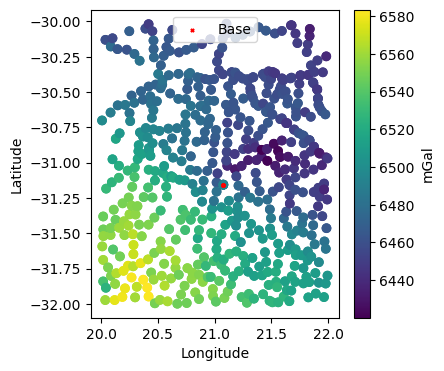

In [10]:
plt.figure(figsize=(4, 4))
# Scatter plot for Combine_data with color mapping based on 'GRAV.' values
sc = plt.scatter(Combine_data['LONGITUDE'], Combine_data['LATITUDE'], c=Combine_data['GRAV.'], cmap='viridis')
# Scatter plot for Data_control with 'x' markers and red color for Base points
plt.scatter(Data_control['LONGITUDE'], Data_control['LATITUDE'], marker='x', s=5, color='red', label='Base')
# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
# Add colorbar to the plot
plt.colorbar(sc, label='mGal')
# Show the plot
plt.show()

# Drift
Gravity value drift due to the stretching of the spring over time. We need to correct that.
Image if we measure the same location at different time, the gravity should be the same.
So we can use our base station to correct the gravity drift. We plot how gravity value change at the start of our survey and the end of our survey at our base station.

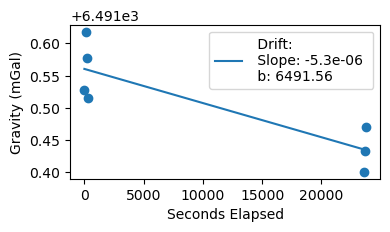

In [11]:
x = np.array(Data_control['seconds_elapsed'])
y = Data_control['GRAV.']
m, b = np.polyfit(x, y, 1) 
slope_label = f" Drift: \n Slope: {m:.1e} \n b: {b:.2f}"

plt.figure(figsize=(4,2))
plt.scatter(x, y)
plt.plot(x, m*x + b, label=slope_label)
plt.legend()
plt.xlabel('Seconds Elapsed')
plt.ylabel('Gravity (mGal)')
Drift = np.vstack((x, m*x + b)).T

In [12]:
# We measure at least 2 time for every location, so we take mean of all measurements at each location
df = Combine_data[['STATION', 'seconds_elapsed','GRAV.','SD.','LONGITUDE','LATITUDE','HEIGHT_SEA_LEVEL_M']]
mean_Data = df.groupby('STATION').mean() 
mean_Data.reset_index(inplace=True)

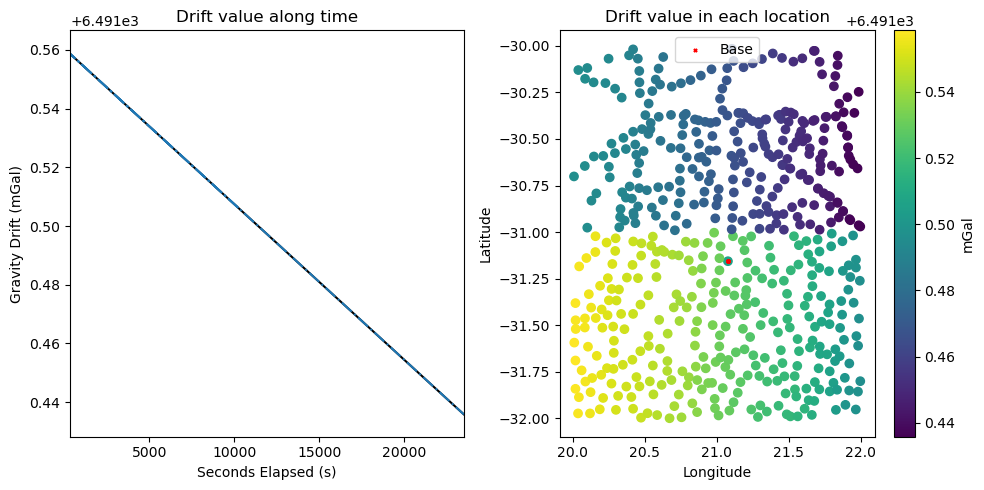

In [13]:
# Calculating the drift value for each location
x_new = mean_Data['seconds_elapsed']
f = interp1d(Drift[:, 0], Drift[:, 1], kind='linear')
y_new = f(x_new)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: Drift over time
axs[0].plot(Drift[:, 0], Drift[:, 1], 'k')
axs[0].plot(x_new, y_new, linestyle='-.')
axs[0].set_xlabel('Seconds Elapsed (s)')
axs[0].set_ylabel('Gravity Drift (mGal)')
axs[0].set_xlim(min(mean_Data['seconds_elapsed']), max(mean_Data['seconds_elapsed']))
axs[0].set_title("Drift value along time")

# Second subplot: Drift for each locations
sc = axs[1].scatter(mean_Data['LONGITUDE'], mean_Data['LATITUDE'], c=y_new, cmap='viridis')
axs[1].scatter(Data_control['LONGITUDE'], Data_control['LATITUDE'], marker='x', s=5, color='red', label='Base')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].legend()
axs[1].set_title("Drift value in each location")
plt.colorbar(sc, ax=axs[1], label='mGal')

# Display the plot
plt.tight_layout()
plt.show()

# Get normal gravity value for each location

Remember CG-5 measure the relative gravity value in each location. After finish the drifting correction, we remove the gravity change due to the stretching of the spring, we also remove the relative value of the basement location. So the gravity in each location is the relative value related to the base station.

In [14]:
# Absolute gravity value in the base station
g_abs =  9.7910e+05

#drift corrected
mean_Data['g_relative'] = mean_Data['GRAV.']- y_new

# Add Absolute gravity value back, now each location represent its absolute value
mean_Data['g_total'] = mean_Data['g_relative'] + g_abs

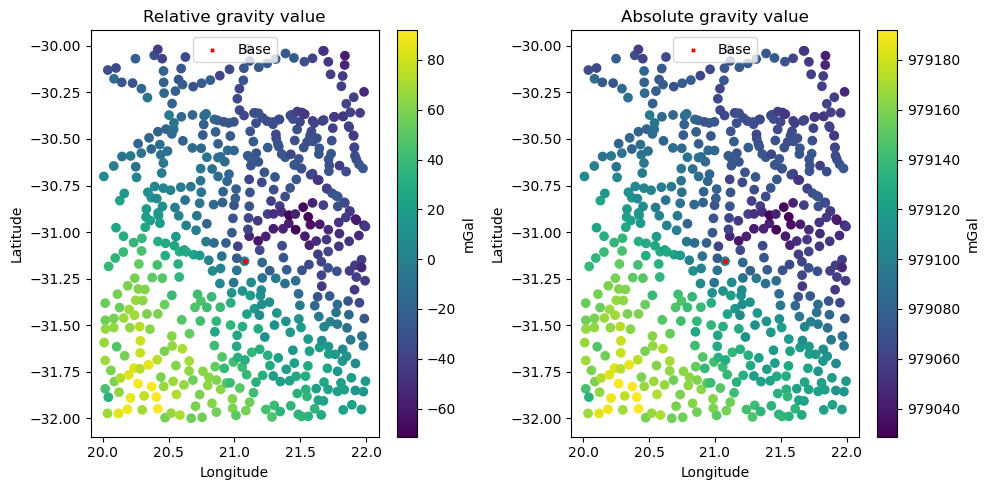

In [15]:
# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: Drift over time
sc = axs[0].scatter(mean_Data['LONGITUDE'], mean_Data['LATITUDE'], c=mean_Data['g_relative'], cmap='viridis')
axs[0].scatter(Data_control['LONGITUDE'], Data_control['LATITUDE'], marker='x', s=5, color='red', label='Base')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].legend()
axs[0].set_title("Relative gravity value")
plt.colorbar(sc, ax=axs[0], label='mGal')

# Second subplot: Drift for each locations
sc = axs[1].scatter(mean_Data['LONGITUDE'], mean_Data['LATITUDE'], c=mean_Data['g_total'], cmap='viridis')
axs[1].scatter(Data_control['LONGITUDE'], Data_control['LATITUDE'], marker='x', s=5, color='red', label='Base')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].legend()
axs[1].set_title("Absolute gravity value")
plt.colorbar(sc, ax=axs[1], label='mGal')

# Display the plot
plt.tight_layout()
plt.show()

In [16]:
# Save the Data to a CSV file
data_array = np.column_stack((mean_Data['LONGITUDE'], mean_Data['LATITUDE'], mean_Data['HEIGHT_SEA_LEVEL_M'], mean_Data['g_total']))
df = pd.DataFrame(data_array, columns=['Lon', 'Lat', 'Height Sea Level', 'Total Gravity'])
df.to_csv('example data/Abs_Grav_CAGE.csv', index=False)

In the next notebook, we will show how to correct the 'normal gravity' to get free-air disturbance